<a href="https://colab.research.google.com/github/rodrigo0345/Aprof2/blob/main/ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Compose, Lambda, Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
import torch
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Normalize
import torch.optim as optim

!pip install decord
import decord
from decord import VideoReader
import os
# from torchinfo import summary
# from livelossplot import PlotLosses

np.random.seed(0)
torch.manual_seed(0)
import random
random.seed(0)

In [21]:
import pandas as pd
import os

path = "drive/MyDrive/suturas-filtered/"
labels_path = "drive/MyDrive/OSATS.xlsx"

info_df = pd.read_excel(labels_path)

# Get list of video files in the directory
video_files = [f.replace("output_prewitt_", "").replace(".mp4", "") for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith(('.mp4', '.avi', '.mov'))]
video_column = 'VIDEO'

info_df = info_df[info_df[video_column].isin(video_files)]
print(f"Number of videos after filtering: {len(info_df)}")
info_df.head()


Number of videos after filtering: 90


,STUDENT,GROUP,TIME,SUTURES,INVESTIGATOR,VIDEO,OSATS_RESPECT,OSATS_MOTION,OSATS_INSTRUMENT,OSATS_SUTURE,OSATS_FLOW,OSATS_KNOWLEDGE,OSATS_PERFORMANCE,OSATS_FINAL_QUALITY,GLOBA_RATING_SCORE
21,ALN135,E-LEARNING,POST,3.5,A,A61V,4,2,3,3,2,3,3,4,24
22,ALN135,E-LEARNING,POST,3.5,B,A61V,4,3,4,3,3,4,3,4,28
23,ALN135,E-LEARNING,POST,3.5,C,A61V,4,3,2,3,3,3,3,3,24
42,BOG917,HMD-BASED,PRE,2.5,A,C16G,3,3,3,2,2,2,2,1,18
43,BOG917,HMD-BASED,PRE,2.5,B,C16G,2,2,3,2,3,3,3,3,21


In [22]:
# used for Task #1
def get_global_rating_score(video: str):
  try:
    score = info_df[info_df['VIDEO'] == video]['GLOBA_RATING_SCORE'].iloc[0]
    # Get GRS score
    if score < 16:
      score = 0
    elif score < 24:
      score = 1
    elif score < 32:
      score = 2
    elif score < 40:
      score = 3
    return score
  except:
    print(f"Video {video} not found")


# used for Task #2
def get_vector_of_ratings(video: str):
  video_data = info_df[info_df['VIDEO'] == video]
  osats_columns = ['OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT',
                    'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE',
                    'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY']
  return video_data[osats_columns].iloc[0].values.tolist()

print(get_global_rating_score("A83X"))
print(get_vector_of_ratings("A31H"))

def update_info_df_with_binned_grs(df):
    updated_df = df.copy()
    binned_scores = updated_df['VIDEO'].apply(get_global_rating_score)
    updated_df['GLOBA_RATING_SCORE'] = binned_scores
    if binned_scores.isnull().any():
        print("Warning: Some videos were not found. Corresponding GRS values are None.")
    return updated_df

# change the dataframe to have GRS
info_df = update_info_df_with_binned_grs(info_df)

2
[1, 2, 1, 1, 1, 2, 2, 1]


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
         for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

print(device)

cuda


In [24]:
train_transform = Compose(
        [ToTensor(),
         Normalize(mean=(0.1307,), std=(0.3081,)) # TODO: acho que devia remover isto
        ])
test_transform = Compose(
        [ToTensor(),
         Normalize(mean=(0.1307,), std=(0.3081,)) # TODO: acho que devia remover isto
        ])

In [25]:
batch_size = 2

In [26]:
class VideoDataset(Dataset):
    def __init__(self, df_dataset, cfg, dataset_path) -> None:
        super().__init__()
        self.df_dataset = df_dataset
        self.dataset_path = dataset_path
        self.cfg = cfg
        self.label = "GLOBA_RATING_SCORE"  # Default to Task 1

    def __len__(self):
        return len(self.df_dataset)

    def set_task_one(self):
        self.label = "GLOBA_RATING_SCORE"

    def set_task_two(self):
        self.label = [
            'OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT',
            'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE',
            'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY'
        ]

    def __getitem__(self, idx):
        video_path = os.path.join(self.dataset_path, "output_prewitt_" + self.df_dataset.iloc[idx]["VIDEO"] + ".mp4")
        vr = decord.VideoReader(video_path)
        total_frames = len(vr)

        num_frames = self.cfg["num_frames"]
        if total_frames >= num_frames:
            indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        else:
            indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)

        frames = vr.get_batch(indices).asnumpy()  # [T, H, W, C], uint8

        # Convert to tensor and normalize to [0, 1]
        frames = torch.from_numpy(frames).float() / 255.0

        # Permute to [T, C, H, W]
        frames = frames.permute(0, 3, 1, 2)

        # Normalize with mean and std
        mean = [0.45, 0.45, 0.45]
        std = [0.225, 0.225, 0.225]
        normalize = Normalize(mean, std)
        frames = normalize(frames)

        # Short side scale
        side_size = 256
        H, W = vr[0].shape[0], vr[0].shape[1]
        if H < W:
            new_H = side_size
            new_W = int(side_size * W / H)
        else:
            new_W = side_size
            new_H = int(side_size * H / W)

        # Resize using interpolate
        frames = F.interpolate(frames, size=(new_H, new_W), mode='bilinear', align_corners=False)

        # Center crop to 256x256
        crop_size = 256
        start_h = (new_H - crop_size) // 2
        start_w = (new_W - crop_size) // 2
        frames = frames[:, :, start_h:start_h + crop_size, start_w:start_w + crop_size]

        # Permute to [C, T, H, W] to match expected output
        frames = frames.permute(1, 0, 2, 3)

        if isinstance(self.label, str):  # Task 1: Single label
            label = self.df_dataset.iloc[idx][self.label]
            label = torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor
        else:  # Task 2: Multiple labels
            label = [self.df_dataset.iloc[idx][col] for col in self.label]
            label = torch.tensor(label, dtype=torch.long)  # Convert to tensor

        return frames, label

# task = 1 | 2
def prepare_data_loaders(path_train, task=1):
    train_df, temp_df = train_test_split(info_df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    cfg = {
        "num_frames": 64 # isto não me convence muito
    }
    train_dataset = VideoDataset(train_df, cfg, path_train)
    val_dataset = VideoDataset(val_df, cfg, path_train)
    test_dataset = VideoDataset(test_df, cfg, path_train)

    train_dataset.set_task_one() if task == 1 else train_dataset.set_task_two()
    val_dataset.set_task_one() if task == 1 else val_dataset.set_task_two()
    test_dataset.set_task_one() if task == 1 else test_dataset.set_task_two()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

train_dl, val_dl, test_dl = prepare_data_loaders(path, task = 1)

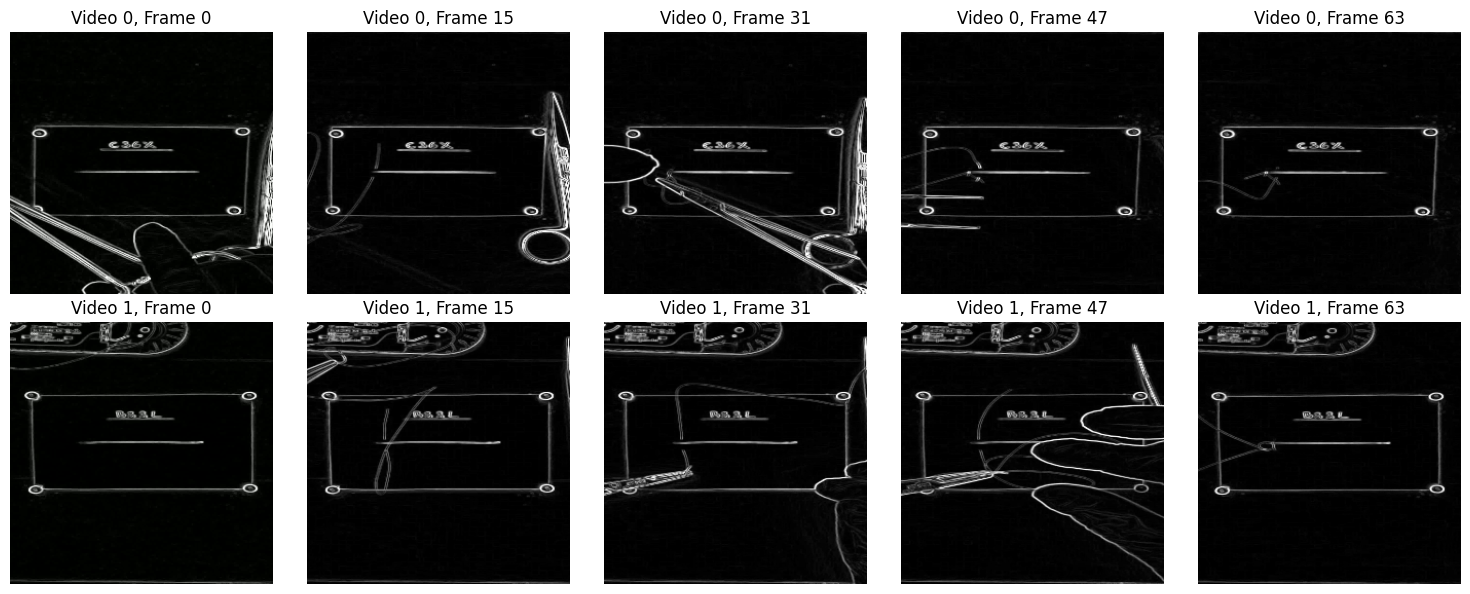

In [27]:
def visualize_video_frames(train_loader, num_videos=2, num_frames=5):
    for batch in train_loader:
        videos, labels = batch
        break

    mean = torch.tensor([0.45, 0.45, 0.45]).view(3, 1, 1, 1).to(videos.device)
    std = torch.tensor([0.225, 0.225, 0.225]).view(3, 1, 1, 1).to(videos.device)
    videos = videos * std + mean

    batch_size = videos.shape[0]
    num_videos = min(num_videos, batch_size)
    fig, axes = plt.subplots(num_videos, num_frames, figsize=(num_frames * 3, num_videos * 3))

    for i in range(num_videos):
        video = videos[i]
        T = video.shape[1]
        indices = np.linspace(0, T - 1, num_frames, dtype=int)

        for j in range(num_frames):
            frame = video[:, indices[j], :, :]
            frame = frame.permute(1, 2, 0).cpu().numpy()
            ax = axes[i, j] if num_videos > 1 else axes[j]
            ax.imshow(frame)
            ax.axis('off')
            ax.set_title(f'Video {i}, Frame {indices[j]}')

    plt.tight_layout()
    plt.show()

visualize_video_frames(train_dl)

In [34]:
# Completamente tirado do chat
class SutureQualityNet(nn.Module):
    def __init__(self, num_frames=16, pretrained=True, num_classes=4):
        super().__init__()
        # ----------------------------
        # 1) Spatio-temporal branch
        #    (R3D-18 backbone → 512-d feature)
        # ----------------------------
        self.video_backbone = torchvision.models.video.r3d_18(pretrained=pretrained)
        # drop its final fc
        self.video_backbone.fc = nn.Identity()
        self.num_classes = num_classes

        # ----------------------------
        # 2) Spatial branch on last frame
        #    (ResNet-50 backbone → 2048-d feature)
        # ----------------------------
        resnet = torchvision.models.resnet50(pretrained=pretrained)
        # modify first conv for RGB input
        self.image_backbone = nn.Sequential(
            *list(resnet.children())[:-1],  # all layers up to avgpool
            nn.Flatten()
        )

        # ----------------------------
        # 3) Fusion head
        # ----------------------------
        # video feature dim = 512
        # image feature dim = 2048
        fusion_dim = 512 + 2048
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, video):
        """
        video: tensor [B, C=3, T, H, W]
        """
        B, C, T, H, W = video.shape

        # Spatio-temporal encoding
        vid_feat = self.video_backbone(video)           # [B, 512]

        # Spatial encoding of last frame
        last_frame = video[:, :, -1, :, :].contiguous() # [B,3,H,W]
        img_feat  = self.image_backbone(last_frame)     # [B,2048]

        # Fuse and classify
        fusion = torch.cat([vid_feat, img_feat], dim=1) # [B,2560]
        out    = self.classifier(fusion)               # [B,1]
        return out


In [29]:
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for videos, labels in train_loader:
            videos = videos.to(device)
            labels = labels.to(device, dtype=torch.long)  # Ensure labels are long
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * videos.size(0)

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for videos, labels in val_loader:
                videos = videos.to(device)
                labels = labels.to(device, dtype=torch.long)
                outputs = model(videos)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * videos.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

In [30]:
print(train_dl.dataset.cfg["num_frames"])
model = SutureQualityNet(num_frames=train_dl.dataset.cfg["num_frames"])
train_model(model, train_dl, val_dl, num_epochs=1)
torch.save(model, "SutureQualityNet.pth")

64


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights

Epoch 1/1, Train Loss: 1.6088, Train Acc: 0.3810, Val Loss: 28.4530, Val Acc: 0.5385


In [31]:
model = None
torch.cuda.empty_cache()
model = torch.load("SutureQualityNet.pth", weights_only=False)

In [33]:
def evaluate_model(model, test_loader):
    model = model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.to(device)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * videos.size(0)

            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_mae = mean_absolute_error(true_labels, predictions)
    test_f1 = f1_score(true_labels, predictions, average='weighted')
    test_accuracy = accuracy_score(true_labels, predictions)

    print(f"Test Loss (CrossEntropy): {test_loss:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_mae, test_f1, test_accuracy

test_loss, test_mae, test_f1, test_accuracy = evaluate_model(model, test_dl)
print(test_accuracy, test_f1)


Test Loss (CrossEntropy): 34.8789, Test MAE: 1.0000
Test F1 Score (weighted): 0.3333, Test Accuracy: 0.5000
0.5 0.3333333333333333
